# Use Gaia catalog through LSST reference catalog pipeline to identify and select isolated stars

This notebook shows how we use convolution to identify the donuts on an image and then use the LSST reference catalog framework to compile a list of all Gaia stars located on the image. We then take this selection of Gaia sources and input them into the database that `ts_wep` uses for Source Selection.

## Overview

The function `insertDataFromRefCat` in `LocalDatabaseFromRefCat` performs all the necessary steps. In this notebook we will walk through the steps in this function to show how it works.

In [1]:
from lsst.ts.wep.bsc.LocalDatabaseFromRefCat import LocalDatabaseFromRefCat

In [2]:
LocalDatabaseFromRefCat.insertDataFromRefCat??

Signature:
LocalDatabaseFromRefCat.insertDataFromRefCat(
    self,
    butlerRootPath,
    settingFileInst,
    visitList,
    defocalState,
    filterType,
    wavefrontSensors,
    camera,
    skiprows=1,
    keepFile=True,
    fileOut='foundDonuts.txt',
)
Docstring: <no docstring>
Source:   
    def insertDataFromRefCat(self, butlerRootPath, settingFileInst,
                            visitList, defocalState,
                            filterType, wavefrontSensors, camera,
                            skiprows=1, keepFile=True,
                            fileOut='foundDonuts.txt'):

        centroidTemplateType = settingFileInst.getSetting("centroidTemplateType")
        donutImgSize = settingFileInst.getSetting("donutImgSizeInPixel")
        overlapDistance = settingFileInst.getSetting("minUnblendedDistance")
        maxSensorStars = settingFileInst.getSetting("maxSensorStars")
        doDeblending = settingFileInst.getSetting("doDeblending")
        blendMagDiff = settingFileIns

## Step 1: Get settings from `ts_wep` policy file

The first few lines of the function get the necessary information on how to compile the sources that we will put into the database and make selections on what stars to keep.

In [3]:
from lsst.ts.wep.ParamReader import ParamReader

In [4]:
ts_wep_policy = '/astro/users/brycek/epyc/users/brycek/Commissioning/aos/ts_wep/policy/default.yaml'
settingFileInst = ParamReader(filePath=ts_wep_policy)

In [5]:
# Type of model donut to convolve with the image to get donut centroids
centroidTemplateType = settingFileInst.getSetting("centroidTemplateType")
print('centroidTemplateType: {}'.format(centroidTemplateType))

# Size of the donut image postage stamps in pixels
donutImgSize = settingFileInst.getSetting("donutImgSizeInPixel")
print('donutImgSizeInPixel: {}'.format(donutImgSize))

# Donuts must be this far apart to count as unblended
overlapDistance = settingFileInst.getSetting("minUnblendedDistance")
print('overlapDistance: {}'.format(overlapDistance))

# Max Number of Stars to add to the database (Not currently in use. Used for debugging sometimes).
maxSensorStars = settingFileInst.getSetting("maxSensorStars")
print('maxSensorStars: {}'.format(maxSensorStars))

# Use blended sources or not
doDeblending = settingFileInst.getSetting("doDeblending")
print('doDeblending: {}'.format(doDeblending))

# If blended objects are included only use objects where the reference catalog magnitudes between stars are at least this far apart
blendMagDiff = settingFileInst.getSetting("blendMagDiff")
print('blendMagDiff'.format(blendMagDiff))

# Location of the reference catalog
refCatDir = settingFileInst.getSetting("refCatDir")
print('refCatDir: {}'.format(refCatDir))

centroidTemplateType: model
donutImgSizeInPixel: 160
overlapDistance: 160
maxSensorStars: 3
doDeblending: False
blendMagDiff
refCatDir: /astro/store/epyc/users/ajc26/LSST-Commissioning/aoc/gaia_refcat


## Step 2: Prepare LSST Reference Catalog Loader

In [6]:
from lsst.daf.persistence import Butler

In [7]:
refButler = Butler(refCatDir)

In [8]:
from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask

In [9]:
refObjLoader = LoadIndexedReferenceObjectsTask(butler=refButler)

## Step 3: Identify Donuts

In [10]:
from lsst.ts.wep.Utility import FilterType, DefocalType
from lsst.ts.wep.bsc.CamFactory import CamFactory, CamType

In [11]:
# Location of the postISRCCD
butlerRootPath = '/astro/store/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_high_full_2020_24_NEW/input/rerun/run1/'
# Visit IDs for intra and extra focal images
visitList = [9006002, 9006001]
# Visit Filter
filterType = FilterType.G
# defocal state
defocalState = DefocalType.Intra
# wavefront sensors
wavefrontSensors = {'R:2,2 S:1,1': '94'}
# camera model
camera = CamFactory.createCam(CamType.ComCam)
field_ra = 197.46441300863182 
field_dec = 24.335542430275815
rotSkyPos = 0
camera.setObsMetaData(field_ra, field_dec, rotSkyPos)

refCatCreator = LocalDatabaseFromRefCat()
refCatCreator.refObjLoader = refObjLoader
sky_df = refCatCreator.identifyDonuts(butlerRootPath, visitList, filterType,
                                      defocalState, wavefrontSensors, camera,
                                      centroidTemplateType, donutImgSize,
                                      overlapDistance, doDeblending,
                                      blendMagDiff, maxSensorStars)

{'visit': 9006002, 'filter': 'g', 'raftName': 'R22', 'detectorName': 'S11'}
0     197.356222
1     197.516807
2     197.355131
3     197.507056
4     197.437275
         ...    
70    197.560212
71    197.534012
72    197.563002
73    197.402252
74    197.451043
Name: ra, Length: 75, dtype: float64
0     197.358730
1     197.520144
2     197.363001
3     197.503663
4     197.444139
         ...    
70    197.555317
71    197.526152
72    197.561532
73    197.404274
74    197.457664
Name: ra, Length: 75, dtype: float64


In [12]:
sky_df.head()

,id,coord_ra,coord_dec,phot_g_mean_flux,phot_bp_mean_flux,phot_rp_mean_flux,phot_g_mean_fluxErr,phot_bp_mean_fluxErr,phot_rp_mean_fluxErr,coord_raErr,...,blended,blended_with,num_blended_neighbors,mag,ra,dec,raft,sensor,x_center,y_center
0,1447085910653936128,3.444516,0.424526,3.047627e+08,3.132486e+08,2.608496e+08,125395.326587,280575.546982,112748.833294,3.654983e-10,...,False,None,0,10.190096,197.358730,24.320857,R22,S11,1818.704893,3768.142909
1,1447093783330220160,3.447319,0.426121,1.633429e+08,1.070358e+08,2.388038e+08,41934.384856,85074.588209,141397.031648,2.073757e-10,...,False,None,0,10.867250,197.520144,24.410831,R22,S11,3461.377858,1136.070493
2,1447088663729181568,3.444497,0.426051,1.038029e+07,8.240021e+06,1.288486e+07,2293.609784,8549.117488,9454.957613,1.147738e-10,...,False,None,0,13.859476,197.363001,24.401743,R22,S11,3390.784881,3784.698649
3,1447083544128184576,3.447148,0.424127,6.282365e+06,4.286748e+06,8.957040e+06,1727.538584,6058.824236,7493.152073,1.210450e-10,...,False,None,0,14.404692,197.503663,24.304713,R22,S11,1405.789087,1295.065615
4,1447094814122350592,3.445931,0.426454,3.647883e+06,2.952669e+06,4.490304e+06,1395.735224,4574.737038,6873.199735,1.748139e-10,...,False,None,0,14.994898,197.444139,24.425823,R22,S11,3804.866981,2438.960346


### Show results on image

In [13]:
data_butler = Butler(butlerRootPath)

In [14]:
r22_s11_exp = data_butler.get('postISRCCD', {'filter': 'g', 'visit':9006002, 'raftName': 'R22', 'detectorName':'S11'})

In [15]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


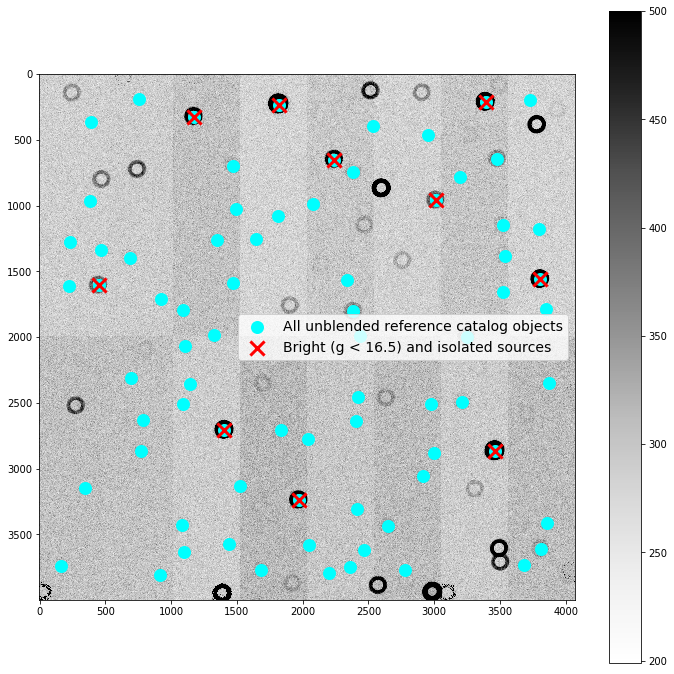

In [16]:
fig = figure(figsize=(12,12))
imshow(r22_s11_exp.image.array, cmap=get_cmap('Greys'), vmax=500)
colorbar()
scatter(sky_df['centroid_x'], sky_df['centroid_y'], marker='.', c='cyan', s=400, lw=3, label='All unblended reference catalog objects')
scatter(sky_df.query('mag < 16.5')['centroid_x'], sky_df.query('mag < 16.5')['centroid_y'], marker='x', c='r', s=200, lw=3, label='Bright (g < 16.5) and isolated sources')
legend(fontsize=14)

## Step 4: Insert Reference Catalog Objects into Database

In [17]:
import os
from lsst.ts.wep.Utility import getModulePath

In [18]:
# Write the reference catalog to file
fileOut = '/astro/store/epyc/projects/lsst_comm/aoclc_output/temp.txt'
refCatCreator.writeSkyFile(sky_df, fileOut)

# Update database name
new_database_name = 'tests/testData/notebook_result.db3'
settingFileInst.updateSetting('defaultBscPath', 'tests/testData/notebook_result.db3')

# Connect to test sqlite database
new_database_path = os.path.join(getModulePath(), new_database_name)
refCatCreator.connect(new_database_path)

# Delete any existing table with same name
refCatCreator.deleteTable(filterType)

# Create new table
refCatCreator.createTable(filterType)

# Insert data into table from text file created
refCatCreator.insertDataByFile(fileOut, filterType, skiprows=1)

In [19]:
import sqlalchemy

In [20]:
engine = sqlalchemy.create_engine('sqlite:///%s' % new_database_path)

In [21]:
import pandas as pd

In [22]:
star_sql_database = pd.read_sql('StarTableG', engine)

In [23]:
star_sql_database

,id,simobjid,ra,decl,gmag,bright_star
0,1,0,197.358730,24.320857,10.190096,0
1,2,1,197.520144,24.410831,10.867250,0
2,3,2,197.363001,24.401743,13.859476,0
3,4,3,197.503663,24.304713,14.404692,0
4,5,4,197.444139,24.425823,14.994898,0
...,...,...,...,...,...,...
70,71,70,197.555317,24.308454,21.213884,0
71,72,71,197.526152,24.251081,21.260339,0
72,73,72,197.561532,24.361303,21.274132,0
73,74,73,197.404274,24.335877,21.345925,0


Here we can see that the reference catalog objects are added to the expected sqlite database for `ts_wep` to use in the wavefront estimation.